# Controls Application Analysis

Here we dump metrics from all applications, console, java, etc. and collect them in a single data frame. This allows us to explore the data and discover insights that would be difficult to know otherwise.

## Single Source of Truth

We will keep all data in the `app_data.json` file. So, if you generate data that could be used for future analysis, add it to the `app_data` data frame and then write the data frame back to the `app_data.json` file.

```python
# Example data concatenation
# app_data = pd.concat([app_data, line_data])
app_data.to_json("app_data.json", orient="records", indent=2)
```

### Output to JSON

If you uncomment this, it will output to `test.json`. Use this as a guide to update the `app_data.json` file. Check the changes with a print or the `test.json` file before committing changes to `app_data.json`.

In [117]:
# app_data = pd.read_json('app_data.json')
# app_data = app_data.merge(line_data, on="program")
# app_data.to_json('test.json', orient='records', indent=2)

## Imports

To install these you can run `python3 -m pip install -r requirements.txt`.

In [118]:
import pandas as pd
# Even though we don't use this, it has useful defaults, so let's keep it.
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

In [125]:
app_data = pd.read_json('app_data.json')

# Define logical conditions to cut application from data
nonobsolete_condition = app_data["status"] == "active"
nonzero_lines_condition = app_data["count"]!=0

# Logical AND all the conditions
cut_condition = nonobsolete_condition*nonzero_lines_condition
print(f'{np.where(cut_condition)[0].size} elements made the cut out of {np.asarray(app_data["count"]).size}.')

lines = np.asarray(app_data['count'])[np.where(cut_condition)]

517 elements made the cut out of 1287.


In [120]:
# Apply fit to data
def func(x, a, b, c):
    return a * np.exp(-1.0*(x/b)) + c # Exponential decay

Decay constant is 3355.7460005803287


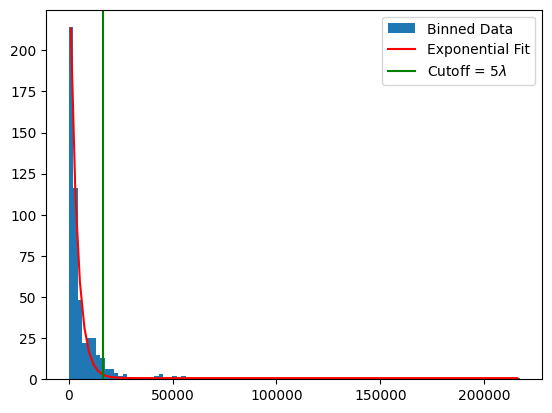

In [121]:
x = np.linspace(0, lines.size - 1, lines.size)
nbins = 100

n, bin_borders, _ = plt.hist(lines, nbins, label="Binned Data")
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
p0 = [1, 1E2, 1]
popt, pcov = curve_fit(func, bin_centers, n, p0)
plt.plot(bin_centers, func(bin_centers, *popt), 'r-', label="Exponential Fit")
#plt.xlim(0,50000)
#plt.gca().set_yscale('log')
cutoff = 5 # units of fit characteristic decay constant
plt.axvline(x = cutoff*popt[1], ymin = 0, ymax = 1, color='green', label = f"Cutoff = {cutoff}"+r"$\lambda$")
plt.legend()

print(f"Decay constant is {popt[1]}")

# Compute total lines of code within the cutoff
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
# Find index that is nearest to the cutoff, integrate number of lines up to cutoff
# Note from Adam: I don't think this is working yet.
#cutoff_index = np.where(lines == find_nearest(lines, func(x,*popt)))[0][0]
#lines_at_cutoff = np.sum(lines[0:cutoff_index])
#print(f"Total lines of code up to cutoff is {lines_at_cutoff}")

In [122]:
# Some statistics to see what's interesting
mean = np.mean(lines)
median = np.median(lines)
mode = stats.mode(lines)[0]
sum = np.sum(lines)
max = np.max(lines)
print(f"Mean: {mean:.0f}, Median: {median:.0f}, Mode: {mode:.0f}, Sum: {sum:.0f}, Max: {max}")

Mean: 7321, Median: 2641, Mode: 242, Sum: 3785050, Max: 216997


In [123]:
# Determine PA# nearest to median
median_index = np.where(lines == find_nearest(lines, np.median(lines)))[0][0]
app_data["program"][median_index]

'pa1654'

#### Ideas:
- Remove unused applications from dataset, if possible (i.e. not mapped to index page, not frequently used over time frame, Linac)
- Weight applications by priority (usage stats and interview criticality), redo analysis to determine window
- Use exponential fit, choose windows as integer multiples fit characteristic time constant (instead of standard deviation)

Maybe for CD-1, do first and third idea above. Priority weighting can refine estimate for CD-2.

John: effort is not linear with lines-of-code. Really wants to see how long it takes to port median application.